Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Bring in the CSV files

In [3]:
# Load files
train = pd.read_csv('/content/drive/MyDrive/machine_learning_stories/Umoja2022/Beg/train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('/content/drive/MyDrive/machine_learning_stories/Umoja2022/Beg/test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('/content/drive/MyDrive/machine_learning_stories/Umoja2022/Beg/SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


Sort the train and test set by date, gives the model a sense of seeing the data as a time series

In [4]:
train = train.sort_values(by=['Datetime']).reset_index(drop=True)

In [5]:
test = test.sort_values(by=['Datetime']).reset_index(drop=True)

In [6]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
mean,40.75120,38.18302,23.31655,78.65362,0.37107
std,28.52618,28.64776,3.83697,14.77272,0.48309
min,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,22.43000,19.52000,20.40000,68.00000,0.00000
50%,36.47000,33.72000,21.90000,84.00000,0.00000
75%,49.42000,47.57000,26.30000,91.00000,1.00000
max,997.96000,997.26000,34.90000,99.00000,1.00000


In [7]:
test.tail()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
127356,ID_0Q6FJWMIY1UD,2022-03-14 14:45:42,16.58000,13.15000,NaN,NaN
127357,ID_J5QHC8KEKLOS,2022-03-14 14:47:04,14.33000,12.77000,NaN,NaN
127358,ID_27Q3I4ZW27OC,2022-03-14 14:48:07,15.60000,15.97000,NaN,NaN
127359,ID_17GIG572BMR3,2022-03-14 14:49:22,12.87000,13.08000,NaN,NaN
127360,ID_XZOXV4ACPR32,2022-03-14 14:50:35,10.57000,11.43000,NaN,NaN


Check out Outliers in the train set for sensor1

In [8]:
import numpy as np
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_zscore(train["Sensor1_PM2.5"])
print("Outliers from Z-scores method: ", sample_outliers)

Outliers from Z-scores method:  [129.98, 127.18, 131.42, 133.37, 135.58, 136.85, 128.73, 135.03, 143.73, 133.38, 140.48, 133.77, 134.05, 130.82, 129.02, 129.12, 130.1, 133.45, 141.98, 141.82, 142.23, 150.68, 145.83, 146.58, 141.85, 155.7, 137.95, 144.77, 139.68, 147.47, 142.65, 147.77, 139.73, 142.23, 128.75, 132.57, 127.2, 127.68, 138.98, 127.45, 138.03, 129.25, 141.17, 135.67, 141.32, 132.03, 141.32, 137.53, 138.5, 138.6, 145.97, 136.73, 145.53, 136.95, 149.33, 133.75, 132.57, 147.12, 139.08, 142.7, 135.92, 143.85, 130.78, 143.02, 136.62, 140.12, 138.62, 143.48, 130.83, 142.65, 131.85, 134.17, 131.15, 133.08, 127.12, 127.07, 127.62, 465.45, 440.12, 431.46, 148.88, 164.38, 145.68, 127.48, 128.2, 126.67, 136.02, 130.77, 131.77, 495.64, 493.32, 472.56, 421.45, 479.0, 491.2, 444.61, 127.17, 284.0, 283.18, 405.97, 133.62, 345.0, 145.82, 144.7, 141.92, 151.13, 154.25, 152.27, 152.88, 148.07, 147.0, 146.0, 149.53, 138.8, 142.52, 127.68, 131.9, 128.0, 128.17, 128.18, 130.3, 139.58, 137.42, 1

In [9]:
train.isnull().sum()

ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

If sensor1 has outliers, drop the row

In [10]:
train = train[train["Sensor1_PM2.5"]<min(sample_outliers)].reset_index(drop = True)

In [11]:
train.isnull().sum()

ID                      0
Datetime                0
Sensor1_PM2.5           0
Sensor2_PM2.5           0
Temperature          3533
Relative_Humidity    3533
Offset_fault            0
dtype: int64

Look at the Temperature and Humidity field, it makes sense because we've sorted it by time. Let's take the advantage to Foward fill the Temperature and Relative Humidity, leveraging the timing.

In [12]:

# applying ffill() method to fill the missing values
test.ffill(axis = 0)

# applying ffill() method to fill the missing values
train.ffill(axis = 0)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17000,9.28000,29.90000,53.00000,0
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93000,11.25000,29.90000,53.00000,0
2,ID_UF68QLIPG3LE,2021-10-15 16:01:01,6.53000,3.15000,29.90000,53.00000,1
3,ID_KKCO4VATOSWB,2021-10-15 16:01:54,8.30000,8.35000,29.90000,53.00000,0
4,ID_8YNKABZP11SS,2021-10-15 16:02:06,6.87000,9.57000,29.90000,53.00000,0
...,...,...,...,...,...,...,...
289323,ID_AATX8BDC1PK6,2022-01-21 07:33:21,49.82000,46.03000,16.90000,79.00000,0
289324,ID_1B5HQEHUQK3H,2022-01-21 07:33:40,40.25000,31.67000,16.90000,79.00000,1
289325,ID_5JPOTNIC5BNN,2022-01-21 07:34:18,44.30000,52.37000,16.90000,79.00000,0
289326,ID_RCP3FX3CB2CK,2022-01-21 07:34:46,48.83000,46.25000,16.90000,79.00000,0


In [13]:
test_orig = test.copy()

In [14]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((289328, 7), (127361, 6), (127361, 2))

Descriptions and Visualizations.

In [15]:
# Train statistical summary
train.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,289328,289328,289328.00000,289328.00000,285795.00000,285795.00000,289328.00000
unique,289328,286059,NaN,NaN,NaN,NaN,NaN
top,ID_37STUCVVPZKP,2021-11-06 18:29:26,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,39.04612,36.57356,23.36399,78.51096,0.37519
std,NaN,NaN,23.10803,23.57386,3.84427,14.83530,0.48417
min,NaN,NaN,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,NaN,NaN,22.18000,19.32000,20.40000,67.00000,0.00000


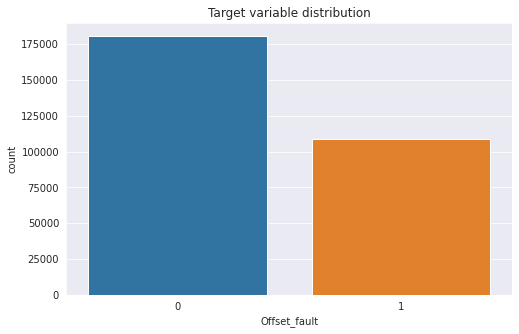

In [16]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

In [17]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

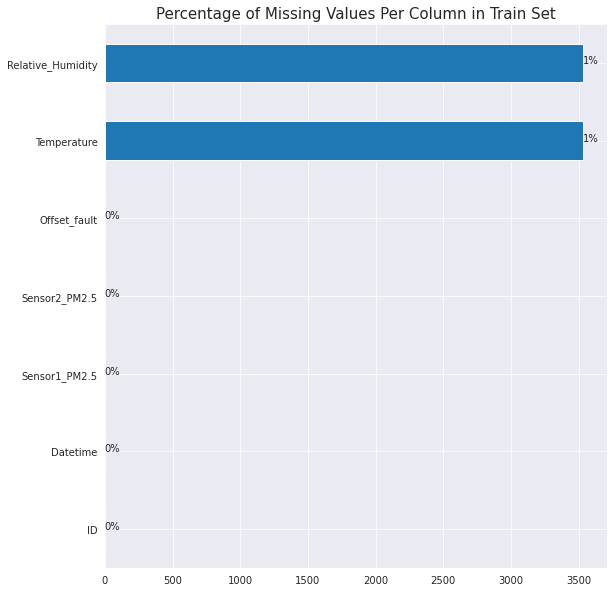

In [18]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Other feature engineering

In [19]:
target = train.Offset_fault
train=train.drop("Offset_fault", axis =1)

In [20]:
train.head(2)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17000,9.28000,29.90000,53.00000
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93000,11.25000,29.90000,53.00000


In [21]:
data = train.append(test)

In [22]:
# Convert datetime variables to datetime objects
data["Datetime"] = pd.to_datetime(data.Datetime)


In [23]:
data.head(2)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17000,9.28000,29.90000,53.00000
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93000,11.25000,29.90000,53.00000


In [24]:
def time_of_day(number):
  if(number>5 and number<12):
    return(1)
  elif(number>12 and number<17):
    return(2)
  else:
    return(3)

In [25]:
data.head(2)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17000,9.28000,29.90000,53.00000
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93000,11.25000,29.90000,53.00000


More Feature Engineering

In [26]:
data["Sensor difference"] = (data["Sensor1_PM2.5"] - data["Sensor2_PM2.5"]).abs()
data["Sensor div"] = (data["Sensor1_PM2.5"] / data["Sensor2_PM2.5"]).abs()
data["Sensor R/T"] = (data["Relative_Humidity"] / data["Temperature"]).abs()
data["SD"] = data[["Sensor1_PM2.5","Sensor2_PM2.5"]].std(axis=1)
data["Mean"] = data[["Sensor1_PM2.5","Sensor2_PM2.5"]].mean(axis=1)

In [27]:
data['Rolling_3'] = data['Sensor1_PM2.5'].rolling(3).mean()
data['Rolling_5'] = data['Sensor1_PM2.5'].rolling(5).mean()

data['Rolling_2_3'] = data['Sensor2_PM2.5'].rolling(3).mean()
data['Rolling_2_5'] = data['Sensor2_PM2.5'].rolling(5).mean()

In [28]:
data["Sensor1_PM2_rolling_mean_60"] = data.rolling(60).mean()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_max_60"] = data.rolling(60).max()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_min_60"] = data.rolling(60).min()["Sensor1_PM2.5"]

data["Sensor1_PM2_rolling_mean_30"] = data.rolling(30).mean()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_max_30"] = data.rolling(30).max()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_min_30"] = data.rolling(30).min()["Sensor1_PM2.5"]

data["Sensor1_PM2_rolling_mean_10"] = data.rolling(10).mean()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_max_10"] = data.rolling(10).max()["Sensor1_PM2.5"]
data["Sensor1_PM2_rolling_min_10"] = data.rolling(10).min()["Sensor1_PM2.5"]


data["Sensor2_PM2_rolling_mean_60"] = data.rolling(60).mean()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_max_60"] = data.rolling(60).max()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_min_60"] = data.rolling(60).min()["Sensor2_PM2.5"]

data["Sensor2_PM2_rolling_mean_30"] = data.rolling(30).mean()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_max_30"] = data.rolling(30).max()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_min_30"] = data.rolling(30).min()["Sensor2_PM2.5"]

data["Sensor2_PM2_rolling_mean_10"] = data.rolling(10).mean()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_max_10"] = data.rolling(10).max()["Sensor2_PM2.5"]
data["Sensor2_PM2_rolling_min_10"] = data.rolling(10).min()["Sensor2_PM2.5"]

In [29]:
data.Relative_Humidity.min()
data.Temperature.max()

34.9

In [30]:
# Extract day, month year and hour from the Datetime column
# day
data['Datetime_day'] = data.Datetime.dt.day

# month
data['Datetime_month'] = data.Datetime.dt.month
 
# year
#data['Datetime_year'] = data.Datetime.dt.year

# hour
data['Datetime_hour'] = data.Datetime.dt.hour


In [31]:
data.head(2)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Sensor difference,Sensor div,Sensor R/T,SD,...,Sensor2_PM2_rolling_min_60,Sensor2_PM2_rolling_mean_30,Sensor2_PM2_rolling_max_30,Sensor2_PM2_rolling_min_30,Sensor2_PM2_rolling_mean_10,Sensor2_PM2_rolling_max_10,Sensor2_PM2_rolling_min_10,Datetime_day,Datetime_month,Datetime_hour
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17000,9.28000,29.90000,53.00000,0.11000,0.98815,1.77258,0.07778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93000,11.25000,29.90000,53.00000,1.32000,0.88267,1.77258,0.93338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16


In [32]:
data.drop("Datetime", axis = 1, inplace = True)

In [33]:
data.head(10)

,ID,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Sensor difference,Sensor div,Sensor R/T,SD,Mean,...,Sensor2_PM2_rolling_min_60,Sensor2_PM2_rolling_mean_30,Sensor2_PM2_rolling_max_30,Sensor2_PM2_rolling_min_30,Sensor2_PM2_rolling_mean_10,Sensor2_PM2_rolling_max_10,Sensor2_PM2_rolling_min_10,Datetime_day,Datetime_month,Datetime_hour
0,ID_37STUCVVPZKP,9.17000,9.28000,29.90000,53.00000,0.11000,0.98815,1.77258,0.07778,9.22500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
1,ID_YZZUOMF0TQIF,9.93000,11.25000,29.90000,53.00000,1.32000,0.88267,1.77258,0.93338,10.59000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
2,ID_UF68QLIPG3LE,6.53000,3.15000,29.90000,53.00000,3.38000,2.07302,1.77258,2.39002,4.84000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
3,ID_KKCO4VATOSWB,8.30000,8.35000,29.90000,53.00000,0.05000,0.99401,1.77258,0.03536,8.32500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
4,ID_8YNKABZP11SS,6.87000,9.57000,29.90000,53.00000,2.70000,0.71787,1.77258,1.90919,8.22000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
5,ID_4M1B7B99G22Z,4.73000,2.37000,29.90000,53.00000,2.36000,1.99578,1.77258,1.66877,3.55000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
6,ID_0NN3PW2X3D2J,8.47000,9.73000,29.90000,53.00000,1.26000,0.87050,1.77258,0.89095,9.10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
7,ID_EKSBUQK9HYXN,5.88000,3.62000,29.90000,53.00000,2.26000,1.62431,1.77258,1.59806,4.75000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
8,ID_Z5SXLLBTR2DG,9.15000,10.85000,29.90000,53.00000,1.70000,0.84332,1.77258,1.20208,10.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16
9,ID_04QJPRKRN029,9.28000,8.67000,29.90000,53.00000,0.61000,1.07036,1.77258,0.43134,8.97500,...,NaN,NaN,NaN,NaN,7.68400,11.25000,2.37000,15,10,16


More Visualizations

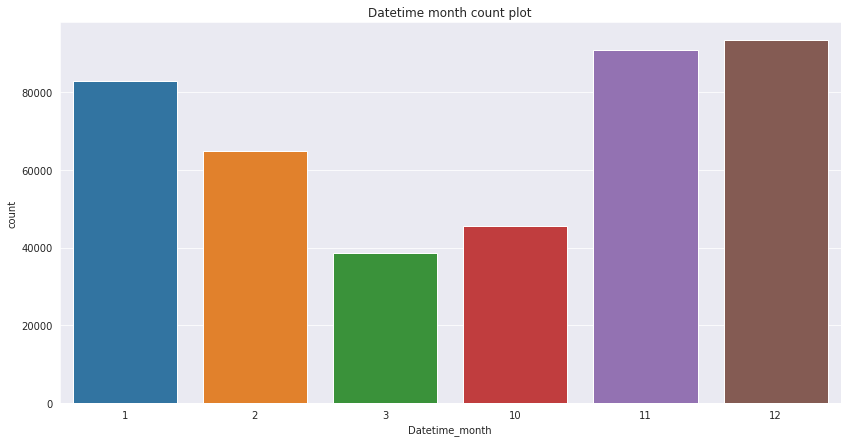

In [34]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = data)
plt.title('Datetime month count plot')
plt.show()

In [35]:
data["time_of_day"] = [time_of_day(i) for i in data.Datetime_hour]

In [36]:
data

,ID,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Sensor difference,Sensor div,Sensor R/T,SD,Mean,...,Sensor2_PM2_rolling_mean_30,Sensor2_PM2_rolling_max_30,Sensor2_PM2_rolling_min_30,Sensor2_PM2_rolling_mean_10,Sensor2_PM2_rolling_max_10,Sensor2_PM2_rolling_min_10,Datetime_day,Datetime_month,Datetime_hour,time_of_day
0,ID_37STUCVVPZKP,9.17000,9.28000,29.90000,53.00000,0.11000,0.98815,1.77258,0.07778,9.22500,...,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16,2
1,ID_YZZUOMF0TQIF,9.93000,11.25000,29.90000,53.00000,1.32000,0.88267,1.77258,0.93338,10.59000,...,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16,2
2,ID_UF68QLIPG3LE,6.53000,3.15000,29.90000,53.00000,3.38000,2.07302,1.77258,2.39002,4.84000,...,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16,2
3,ID_KKCO4VATOSWB,8.30000,8.35000,29.90000,53.00000,0.05000,0.99401,1.77258,0.03536,8.32500,...,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16,2
4,ID_8YNKABZP11SS,6.87000,9.57000,29.90000,53.00000,2.70000,0.71787,1.77258,1.90919,8.22000,...,NaN,NaN,NaN,NaN,NaN,NaN,15,10,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127356,ID_0Q6FJWMIY1UD,16.58000,13.15000,NaN,NaN,3.43000,1.26084,NaN,2.42538,14.86500,...,17.26633,24.78000,12.58000,14.85900,19.33000,12.58000,14,3,14,2
127357,ID_J5QHC8KEKLOS,14.33000,12.77000,NaN,NaN,1.56000,1.12216,NaN,1.10309,13.55000,...,17.00433,24.78000,12.58000,14.20300,17.55000,12.58000,14,3,14,2
127358,ID_27Q3I4ZW27OC,15.60000,15.97000,NaN,NaN,0.37000,0.97683,NaN,0.26163,15.78500,...,16.71067,23.03000,12.58000,14.52200,17.55000,12.58000,14,3,14,2
127359,ID_17GIG572BMR3,12.87000,13.08000,NaN,NaN,0.21000,0.98394,NaN,0.14849,12.97500,...,16.50167,23.03000,12.58000,14.07500,16.75000,12.58000,14,3,14,2


In [37]:
data = data.drop("ID", axis = 1)
# Separate train and test data from the combined dataframe
df_train = data[:train.shape[0]]
df_test = data[train.shape[0]:]

X = df_train
y = target

# Check the shapes of the split dataset
df_train.shape, df_test.shape

((289328, 35), (127361, 35))

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289328 entries, 0 to 289327
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Sensor1_PM2.5                289328 non-null  float64
 1   Sensor2_PM2.5                289328 non-null  float64
 2   Temperature                  285795 non-null  float64
 3   Relative_Humidity            285795 non-null  float64
 4   Sensor difference            289328 non-null  float64
 5   Sensor div                   289328 non-null  float64
 6   Sensor R/T                   285795 non-null  float64
 7   SD                           289328 non-null  float64
 8   Mean                         289328 non-null  float64
 9   Rolling_3                    289326 non-null  float64
 10  Rolling_5                    289324 non-null  float64
 11  Rolling_2_3                  289326 non-null  float64
 12  Rolling_2_5                  289324 non-null  float64
 13 

Modelling

In [39]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


In [40]:
from catboost import CatBoostClassifier
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
fold=StratifiedKFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.2,
                              bootstrap_type='Bernoulli',metric_period=100,max_depth = 8,
                     use_best_model=True)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)
    preds=m2.predict(X_test)
    print("Accuracy: ",(accuracy_score(y_test,preds)))
    errcb2.append((accuracy_score(y_test,preds)))
    p2 = m2.predict(df_test)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.9337660	test: 0.9337660	test1: 0.9796772	best: 0.9796772 (0)	total: 210ms	remaining: 2m 48s
100:	learn: 0.9928301	test: 0.9928301	test1: 0.9854146	best: 0.9945391 (16)	total: 10.5s	remaining: 1m 12s
200:	learn: 0.9953379	test: 0.9953379	test1: 0.9875229	best: 0.9945391 (16)	total: 33s	remaining: 1m 38s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9945391076
bestIteration = 16

Shrink model to first 17 iterations.
Accuracy:  0.9945391075934055


0:	learn: 0.9345648	test: 0.9345648	test1: 0.9680296	best: 0.9680296 (0)	total: 356ms	remaining: 4m 44s
100:	learn: 0.9925191	test: 0.9925191	test1: 0.9946774	best: 0.9946774 (95)	total: 10.2s	remaining: 1m 10s
200:	learn: 0.9952764	test: 0.9952764	test1: 0.9950921	best: 0.9951267 (159)	total: 19.3s	remaining: 57.5s
300:	learn: 0.9968548	test: 0.9968548	test1: 0.9952995	best: 0.9954377 (282)	total: 28.6s	remaining: 47.4s
400:	learn: 0.9977765	test: 0.9977765	test1: 0.9956451	best: 0.9956797 (391)	total: 45.8s	remaining: 45.6s
500:	learn: 0.9983871	test: 0.9983871	test1: 0.9956105	best: 0.9956797 (391)	total: 55s	remaining: 32.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9956796737
bestIteration = 391

Shrink model to first 392 iterations.
Accuracy:  0.99567967372896


0:	learn: 0.9348605	test: 0.9348605	test1: 0.9607714	best: 0.9607714 (0)	total: 138ms	remaining: 1m 50s
100:	learn: 0.9927072	test: 0.9927072	test1: 0.9941244	best: 0.9941589 (96)	total: 9.59s	remaining: 1m 6s
200:	learn: 0.9953724	test: 0.9953724	test1: 0.9946774	best: 0.9947810 (192)	total: 18.8s	remaining: 55.9s
300:	learn: 0.9968817	test: 0.9968817	test1: 0.9952304	best: 0.9953340 (244)	total: 27.9s	remaining: 46.3s
400:	learn: 0.9979070	test: 0.9979070	test1: 0.9953340	best: 0.9954032 (360)	total: 39.1s	remaining: 38.9s
500:	learn: 0.9984562	test: 0.9984562	test1: 0.9953686	best: 0.9954377 (433)	total: 48.3s	remaining: 28.8s
600:	learn: 0.9989670	test: 0.9989670	test1: 0.9954377	best: 0.9954723 (530)	total: 57.5s	remaining: 19s
700:	learn: 0.9993126	test: 0.9993126	test1: 0.9955069	best: 0.9955069 (697)	total: 1m 6s	remaining: 9.4s
799:	learn: 0.9994624	test: 0.9994624	test1: 0.9955414	best: 0.9955760 (760)	total: 1m 16s	remaining: 0us

bestTest = 0.9955759859
bestIteration = 760


0:	learn: 0.9343305	test: 0.9343305	test1: 0.9677531	best: 0.9677531 (0)	total: 141ms	remaining: 1m 52s
100:	learn: 0.9928608	test: 0.9928608	test1: 0.9951612	best: 0.9951958 (96)	total: 9.64s	remaining: 1m 6s
200:	learn: 0.9954915	test: 0.9954915	test1: 0.9956451	best: 0.9958525 (175)	total: 18.9s	remaining: 56.2s
300:	learn: 0.9968471	test: 0.9968471	test1: 0.9958870	best: 0.9958870 (300)	total: 28.1s	remaining: 46.6s
400:	learn: 0.9976881	test: 0.9976881	test1: 0.9962327	best: 0.9963709 (364)	total: 37.1s	remaining: 36.9s
500:	learn: 0.9984255	test: 0.9984255	test1: 0.9959907	best: 0.9963709 (364)	total: 46.3s	remaining: 27.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9963709259
bestIteration = 364

Shrink model to first 365 iterations.
Accuracy:  0.9963709259323265


0:	learn: 0.9366117	test: 0.9366117	test1: 0.9508865	best: 0.9508865 (0)	total: 148ms	remaining: 1m 58s
100:	learn: 0.9930337	test: 0.9930337	test1: 0.9928801	best: 0.9929147 (97)	total: 9.55s	remaining: 1m 6s
200:	learn: 0.9957718	test: 0.9957718	test1: 0.9922925	best: 0.9931220 (154)	total: 18.8s	remaining: 56.1s
300:	learn: 0.9970737	test: 0.9970737	test1: 0.9929492	best: 0.9931220 (154)	total: 28.1s	remaining: 46.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9931220406
bestIteration = 154

Shrink model to first 155 iterations.
Accuracy:  0.9931220405765043


0:	learn: 0.9380710	test: 0.9380710	test1: 0.9382712	best: 0.9382712 (0)	total: 142ms	remaining: 1m 53s
100:	learn: 0.9930375	test: 0.9930375	test1: 0.9917395	best: 0.9917395 (95)	total: 9.54s	remaining: 1m 6s
200:	learn: 0.9957449	test: 0.9957449	test1: 0.9930184	best: 0.9930184 (200)	total: 18.8s	remaining: 56s
300:	learn: 0.9971850	test: 0.9971850	test1: 0.9933294	best: 0.9934331 (264)	total: 28.6s	remaining: 47.5s
400:	learn: 0.9980107	test: 0.9980107	test1: 0.9933294	best: 0.9936059 (326)	total: 37.8s	remaining: 37.6s
500:	learn: 0.9986021	test: 0.9986021	test1: 0.9930184	best: 0.9936059 (326)	total: 46.9s	remaining: 28s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9936059171
bestIteration = 326

Shrink model to first 327 iterations.
Accuracy:  0.9936059171188608


0:	learn: 0.9380172	test: 0.9380172	test1: 0.9368541	best: 0.9368541 (0)	total: 140ms	remaining: 1m 51s
100:	learn: 0.9940705	test: 0.9940705	test1: 0.9803339	best: 0.9804030 (93)	total: 9.58s	remaining: 1m 6s
200:	learn: 0.9963018	test: 0.9963018	test1: 0.9815090	best: 0.9816473 (183)	total: 18.8s	remaining: 56s
300:	learn: 0.9975000	test: 0.9975000	test1: 0.9817164	best: 0.9818546 (208)	total: 27.9s	remaining: 46.2s
400:	learn: 0.9984485	test: 0.9984485	test1: 0.9820620	best: 0.9821311 (386)	total: 37.2s	remaining: 37s
600:	learn: 0.9991628	test: 0.9991628	test1: 0.9820620	best: 0.9822348 (439)	total: 55.1s	remaining: 18.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9822348184
bestIteration = 439

Shrink model to first 440 iterations.
Accuracy:  0.9822348183734836


0:	learn: 0.9437816	test: 0.9437816	test1: 0.8642035	best: 0.8642035 (0)	total: 142ms	remaining: 1m 53s
100:	learn: 0.9941666	test: 0.9941666	test1: 0.9599419	best: 0.9599419 (97)	total: 9.63s	remaining: 1m 6s
200:	learn: 0.9964784	test: 0.9964784	test1: 0.9644351	best: 0.9646770 (199)	total: 18.9s	remaining: 56.3s
300:	learn: 0.9976228	test: 0.9976228	test1: 0.9651609	best: 0.9652300 (298)	total: 28.1s	remaining: 46.6s
400:	learn: 0.9984408	test: 0.9984408	test1: 0.9659904	best: 0.9660941 (393)	total: 37.4s	remaining: 37.2s
500:	learn: 0.9989938	test: 0.9989938	test1: 0.9663360	best: 0.9665780 (492)	total: 46.5s	remaining: 27.7s
600:	learn: 0.9993395	test: 0.9993395	test1: 0.9655065	best: 0.9665780 (492)	total: 55.4s	remaining: 18.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.966577956
bestIteration = 492

Shrink model to first 493 iterations.
Accuracy:  0.9665779559672346


0:	learn: 0.9363585	test: 0.9363585	test1: 0.9040509	best: 0.9040509 (0)	total: 142ms	remaining: 1m 53s
100:	learn: 0.9936251	test: 0.9936251	test1: 0.9767731	best: 0.9767731 (100)	total: 9.65s	remaining: 1m 6s
200:	learn: 0.9962557	test: 0.9962557	test1: 0.9790889	best: 0.9790889 (200)	total: 18.9s	remaining: 56.3s
300:	learn: 0.9974731	test: 0.9974731	test1: 0.9792272	best: 0.9798493 (254)	total: 28.1s	remaining: 46.6s
400:	learn: 0.9982373	test: 0.9982373	test1: 0.9798147	best: 0.9799530 (394)	total: 37.2s	remaining: 37s
500:	learn: 0.9986828	test: 0.9986828	test1: 0.9798839	best: 0.9801258 (452)	total: 46.2s	remaining: 27.6s
600:	learn: 0.9989900	test: 0.9989900	test1: 0.9800221	best: 0.9802641 (549)	total: 55.2s	remaining: 18.3s
700:	learn: 0.9992281	test: 0.9992281	test1: 0.9806788	best: 0.9807825 (683)	total: 1m 4s	remaining: 9.1s
799:	learn: 0.9994931	test: 0.9994931	test1: 0.9805060	best: 0.9808517 (748)	total: 1m 13s	remaining: 0us

bestTest = 0.9808516521
bestIteration = 748

0:	learn: 0.9428870	test: 0.9428870	test1: 0.8874257	best: 0.8874257 (0)	total: 139ms	remaining: 1m 51s
100:	learn: 0.9932295	test: 0.9932295	test1: 0.9765657	best: 0.9783631 (79)	total: 9.56s	remaining: 1m 6s
200:	learn: 0.9958179	test: 0.9958179	test1: 0.9815084	best: 0.9819923 (158)	total: 18.8s	remaining: 56s
300:	learn: 0.9970852	test: 0.9970852	test1: 0.9830637	best: 0.9830637 (300)	total: 28s	remaining: 46.4s
400:	learn: 0.9979378	test: 0.9979378	test1: 0.9846191	best: 0.9847228 (388)	total: 37.3s	remaining: 37.1s
500:	learn: 0.9985944	test: 0.9985944	test1: 0.9852067	best: 0.9852758 (499)	total: 46.7s	remaining: 27.9s
600:	learn: 0.9990130	test: 0.9990130	test1: 0.9853449	best: 0.9856560 (547)	total: 56s	remaining: 18.5s
700:	learn: 0.9992857	test: 0.9992857	test1: 0.9856215	best: 0.9856560 (547)	total: 1m 5s	remaining: 9.19s
799:	learn: 0.9994470	test: 0.9994470	test1: 0.9858980	best: 0.9859325 (768)	total: 1m 17s	remaining: 0us

bestTest = 0.9859325315
bestIteration = 768

Sh

0.9884490608792162

See Feature importance

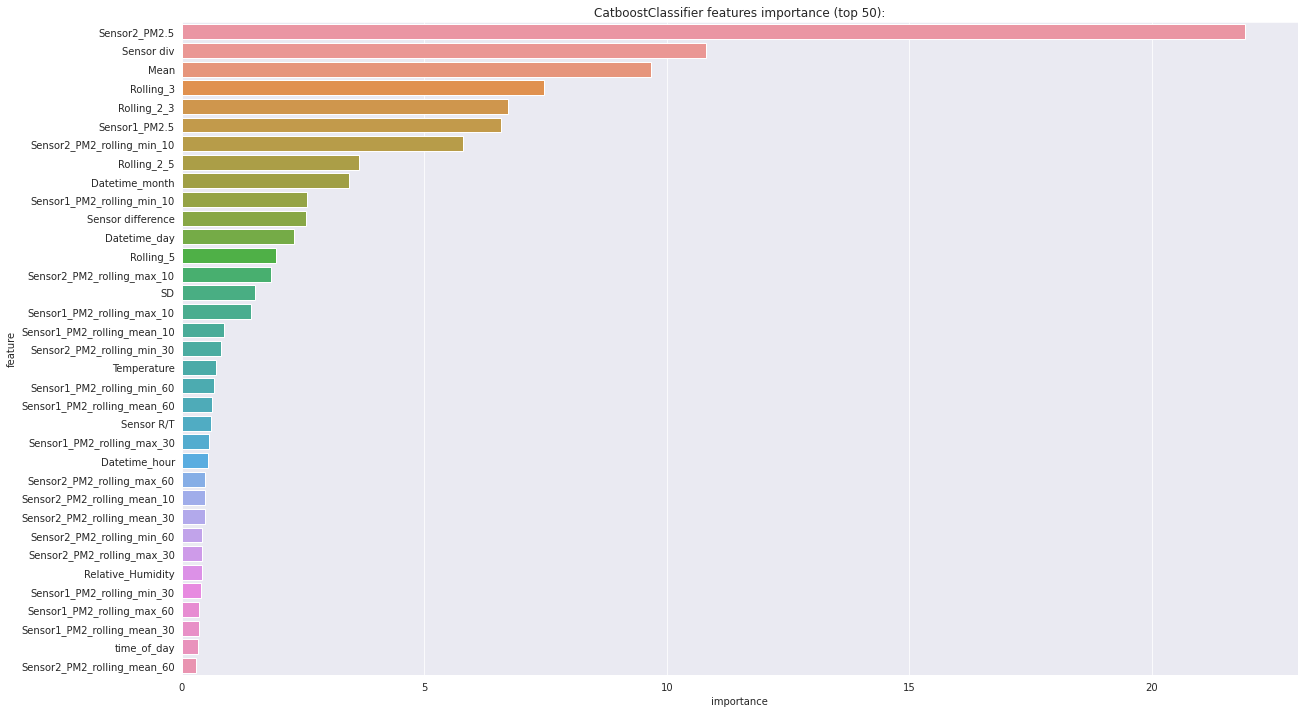

In [41]:
#0.984
feature_importance_df = pd.DataFrame(m2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

Make submissions

In [42]:
samplesubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [43]:
predictions = pd.DataFrame(y_pred_totcb2)

In [44]:
len(y_pred_totcb2)

10

In [45]:
#predictions = predictions.mode()
predictions = np.where(np.mean(predictions,axis=0)> 0.45, 1, 0)

In [46]:
predictions = predictions.T
predictions

array([0, 0, 1, ..., 0, 1, 1])

In [47]:
sub = predictions

In [48]:
sum(sub)

41771

In [49]:
samplesubmission.Offset_fault  = sub
samplesubmission.ID = test_orig.ID

In [50]:
samplesubmission.Offset_fault.value_counts()

0    85590
1    41771
Name: Offset_fault, dtype: int64

In [51]:
samplesubmission.head()

,ID,Offset_fault
0,ID_H9H3ENR9M13N,0
1,ID_JLD6XFEW7EAM,0
2,ID_OQ01HEDYRZEU,1
3,ID_NHK3H46SLYA2,1
4,ID_NGRS57K2NFUF,0


In [52]:
# Write to csv file to submit to Zindi
name = "Reproducibility.csv"
samplesubmission.to_csv(name, index = False)
from google.colab import files
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>